
Processing: hà_nội.parquet

📊 Statistics:
   Routes processed: 109
   Total distance analyzed: 1430.48 km
   Straight: 761.24 km (53.2%)
   Left: 336.43 km (23.5%)
   Right: 332.81 km (23.3%)


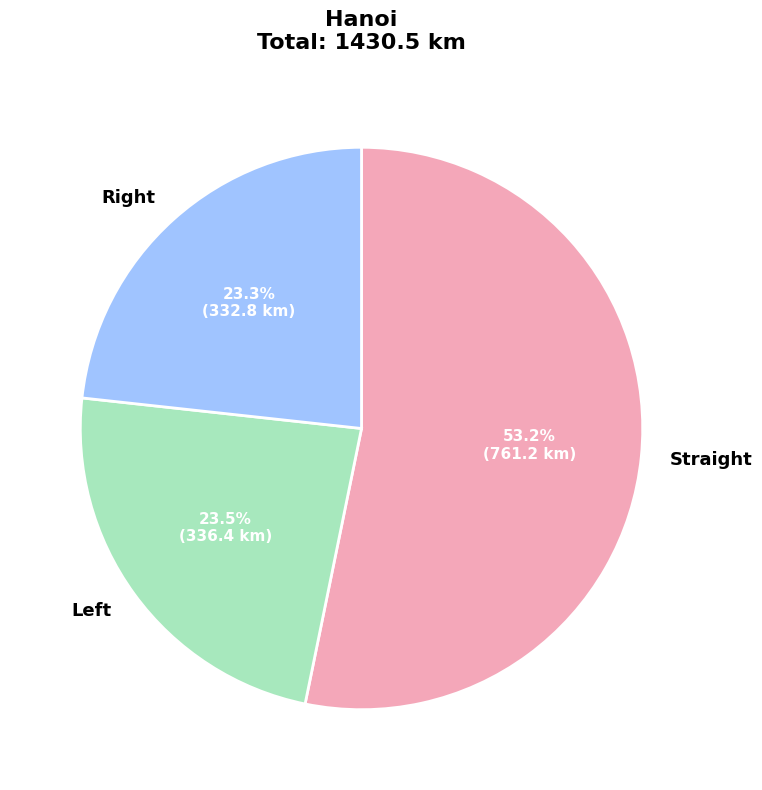

✅ Saved: /content/distance_distribution_hà_nội.png


Processing: singapore.parquet

📊 Statistics:
   Routes processed: 1165
   Total distance analyzed: 14829.74 km
   Straight: 10689.74 km (72.1%)
   Left: 2007.22 km (13.5%)
   Right: 2132.78 km (14.4%)


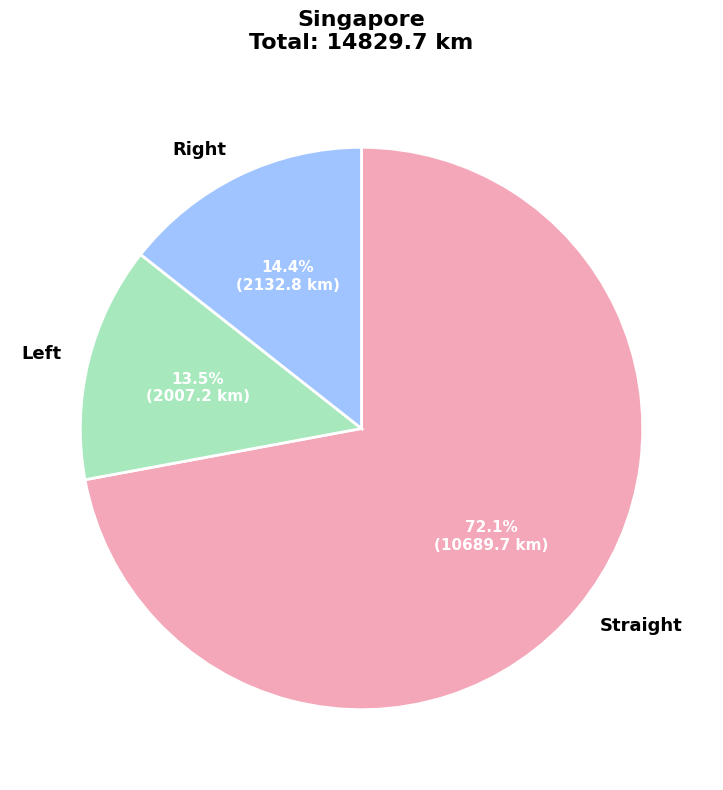

✅ Saved: /content/distance_distribution_singapore.png



In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
from math import atan2, degrees

# --- Configuration ---
content_dir = '/content'
parquet_files = [f for f in os.listdir(content_dir) if f.endswith('.parquet')]

# --- Custom titles for specific files ---
custom_titles = {
    "singapore.parquet": "Singapore",
    "hà_nội.parquet": "Hanoi",
}

# --- Artistic Color Palettes ---
artistic_palettes = {
    "sunset": {
        "Straight": "#FF6F61",  # Coral Red
        "Left": "#6B5B95",      # Royal Purple
        "Right": "#88B04B"      # Wasabi Green
    },
    "tropical": {
        "Straight": "#FCE205",  # Neon Yellow
        "Left": "#08F7FE",      # Electric Cyan
        "Right": "#FE53BB"      # Hot Pink
    },
    "nordic": {
        "Straight": "#F4A7B9",  # Pastel Pink
        "Left": "#A7E8BD",      # Mint Green
        "Right": "#A0C4FF"      # Soft Blue
    }
}

# --- Choose your palette ---
palette_choice = "nordic"  # Options: "sunset", "tropical", "nordic"
turn_colors = artistic_palettes[palette_choice]

# --- TUNING PARAMETERS ---
TURN_THRESHOLD = 45  # degrees: turns > this are counted
MIN_SEGMENT_LENGTH = 20  # meters: minimum distance between analyzed points

# --- Helper functions ---
def extract_route_coordinates(geometry):
    if geometry is None or geometry.is_empty:
        return None
    return [(coord[1], coord[0]) for coord in geometry.coords]

def haversine_distance(p1, p2):
    """Calculate distance in meters between two lat/lon points"""
    lat1, lon1 = np.radians(p1)
    lat2, lon2 = np.radians(p2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371000 * c  # Earth radius in meters

def compute_azimuth(p1, p2):
    lat1, lon1 = np.radians(p1)
    lat2, lon2 = np.radians(p2)
    d_lon = lon2 - lon1
    x = np.sin(d_lon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
    az = np.degrees(atan2(x, y))
    return (az + 360) % 360

def analyze_route_by_distance(route, threshold=45, min_distance=20):
    """
    Analyzes route and returns distance covered in each direction category.
    Returns dict with distances in meters for Straight, Left, Right.
    """
    if route is None or len(route) < 3:
        return {"Straight": 0, "Left": 0, "Right": 0}

    distance_by_direction = {
        "Straight": 0,
        "Left": 0,
        "Right": 0
    }

    i = 0
    current_direction = None
    distance_in_current_direction = 0

    while i < len(route) - 1:
        # Find next point that's far enough away
        j = i + 1
        while j < len(route) and haversine_distance(route[i], route[j]) < min_distance:
            j += 1

        if j >= len(route):
            # Add remaining distance to current direction
            if current_direction and i < len(route) - 1:
                for k in range(i, len(route) - 1):
                    distance_in_current_direction += haversine_distance(route[k], route[k+1])
                distance_by_direction[current_direction] += distance_in_current_direction
            break

        # Calculate distance traveled to this point
        segment_distance = 0
        for k in range(i, j):
            segment_distance += haversine_distance(route[k], route[k+1])

        # Determine direction at point j if we have a next point
        if j < len(route) - 1:
            k = j + 1
            while k < len(route) and haversine_distance(route[j], route[k]) < min_distance:
                k += 1

            if k < len(route):
                # Compute turn angle
                az1 = compute_azimuth(route[i], route[j])
                az2 = compute_azimuth(route[j], route[k])
                delta = (az2 - az1 + 180) % 360 - 180

                if abs(delta) <= threshold:
                    new_direction = "Straight"
                elif delta > 0:
                    new_direction = "Right"
                else:
                    new_direction = "Left"

                # If direction changed, record the accumulated distance
                if current_direction and new_direction != current_direction:
                    distance_by_direction[current_direction] += distance_in_current_direction
                    distance_in_current_direction = segment_distance
                    current_direction = new_direction
                else:
                    # Continue in same direction
                    distance_in_current_direction += segment_distance
                    if current_direction is None:
                        current_direction = new_direction
            else:
                # No more points to determine direction
                if current_direction:
                    distance_in_current_direction += segment_distance
                    distance_by_direction[current_direction] += distance_in_current_direction
                break
        else:
            # This is the last point
            if current_direction:
                distance_in_current_direction += segment_distance
                distance_by_direction[current_direction] += distance_in_current_direction
            break

        i = j

    return distance_by_direction

# --- Process each parquet file ---
for parquet_file in parquet_files:
    print(f"\n{'='*60}")
    print(f"Processing: {parquet_file}")
    print(f"{'='*60}")

    filepath = os.path.join(content_dir, parquet_file)
    gdf = gpd.read_parquet(filepath)

    total_distances = {
        "Straight": 0,
        "Left": 0,
        "Right": 0
    }

    routes_processed = 0

    for geom in gdf.geometry:
        coords = extract_route_coordinates(geom)
        if coords is None or len(coords) < 3:
            continue

        distances = analyze_route_by_distance(
            coords,
            threshold=TURN_THRESHOLD,
            min_distance=MIN_SEGMENT_LENGTH
        )

        total_distances["Straight"] += distances["Straight"]
        total_distances["Left"] += distances["Left"]
        total_distances["Right"] += distances["Right"]
        routes_processed += 1

    total_distance = sum(total_distances.values())

    if total_distance == 0:
        print(f"⚠️  No valid distance data in {parquet_file}")
        continue

    # Convert to kilometers for readability
    total_km = total_distance / 1000

    # --- Print Statistics ---
    print(f"\n📊 Statistics:")
    print(f"   Routes processed: {routes_processed}")
    print(f"   Total distance analyzed: {total_km:.2f} km")
    print(f"   Straight: {total_distances['Straight']/1000:.2f} km ({100*total_distances['Straight']/total_distance:.1f}%)")
    print(f"   Left: {total_distances['Left']/1000:.2f} km ({100*total_distances['Left']/total_distance:.1f}%)")
    print(f"   Right: {total_distances['Right']/1000:.2f} km ({100*total_distances['Right']/total_distance:.1f}%)")

    labels = list(total_distances.keys())
    values = list(total_distances.values())
    colors = [turn_colors[label] for label in labels]

    # --- Custom title ---
    chart_title = custom_titles.get(
        parquet_file,
        f"Distance Distribution by Direction - {parquet_file}"
    )

    # --- Pie Chart ---
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        values,
        labels=labels,
        colors=colors,
        autopct=lambda pct: f'{pct:.1f}%\n({pct*total_km/100:.1f} km)',
        startangle=90,
        counterclock=False,
        wedgeprops={"edgecolor": "white", "linewidth": 2}
    )

    # Style improvements
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_weight('bold')

    for text in texts:
        text.set_fontsize(13)
        text.set_weight('bold')

    plt.title(f"{chart_title}\nTotal: {total_km:.1f} km",
              fontsize=16, weight='bold', pad=20)
    plt.tight_layout()

    out_path = f"/content/distance_distribution_{parquet_file[:-8]}.png"
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f"✅ Saved: {out_path}\n")